In [1]:
import pandas as pd
import librosa
import numpy as np
from sklearn.metrics import f1_score
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle


C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [19]:
def remove_label_bug(df):
    '''Remove any entries where the label end_time is not at least 1 sample greater than the label start_time.
    This step can be done more efficiently when loading data into .wav files, but for readability and ease of use we will
    pre-process the dataframes first by removing any entries with incorrect labels.'''
    idx_noise = []
    for i, item in enumerate(range(len(df))):
        # Check for entry errors
        label_duration = df.iloc[i]["fine_end_time"] - df.iloc[i]["fine_start_time"]
        if label_duration <= 0:
            print('Label duration of', label_duration, 'seconds at path', df.iloc[i]["path"], '... deleting index', i)
            idx_noise.append(i)
    df_clean = df.drop(index = df.index[idx_noise])
    print('Old dataframe length:', len(df))
    print('New dataframe length:', len(df_clean))
    return df_clean

In [20]:
df = pd.read_csv('../../SQLqueries/fine_path_species_label.csv', header = None)
df.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df = remove_label_bug(df)

Label duration of 0.0 seconds at path  '/Thai/sounds/18 June 2018_251cow.wav' ... deleting index 1560
Old dataframe length: 2006
New dataframe length: 2005


In [21]:
df_noise = pd.read_csv('../../SQLqueries/fine_path_non_mosquito.csv', header = None)
df_noise.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df_noise = remove_label_bug(df_noise)

Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 933
Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 935
Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 936
Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 938
Old dataframe length: 1063
New dataframe length: 1059


In [22]:
# Append larvae recordings from dataframe to mosquito instead of noise.
#This is a hotfix to merge the two types from the database
# Note that species information has gone missing for this field.
df = df.append(df_noise[df_noise["sound_type"] == " 'larvae'"])

In [23]:
# Select noise data as labelled entries of all except larvae type
df_noise = df_noise[df_noise["sound_type"] != " 'larvae'"]

In [71]:
# See list of paths used in dataframe
df["path"].unique()

array([" '/CDC/sounds/CDC_Ae-albopictus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-albimanus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-arabiensis_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-atroparvus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-coluzzii_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-dirus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-farauti_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-freeborni_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-funestus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-merus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-minimus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-quadriannulatus_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-quadrimaculatus_labelled_800.wav'",
       " '/Culex/sounds/R4_cleaned recording_12-10-17.wav'",
       " '/CDC/sounds/CDC_An-sinensis_labelled_800.wav'",
       " '/CDC/sounds/CDC_An-stephensi_labelled_800.wav'",
       " '/CDC/sounds/CDC_Cx-quinquefasciatus_labelled

In [25]:
df_noise["path"].unique()

array([" '/Bednet/sounds/PH1 01 JULY (2ND HOUR) - DETECTION TRIAL.wav'",
       " '/Bednet/sounds/PH1 30 JUNE (1ST HOUR) - DETECTION TRIAL.wav'",
       " '/Culex/sounds/R4_cleaned recording_12-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_13-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_16-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_17-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_18-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_TEL_19-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_TEL_20-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_TEL_23-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_TEL_24-10-17.wav'",
       " '/Culex/sounds/R4_cleaned recording_TEL_25-10-17.wav'",
       " '/Culex/sounds/UNFINISHED - recordings and labels 17-10-17-R4.wav'",
       " '/Culex/sounds/UNFINISHED - recordings and labels 18-10-17-R4.wav'",
       " '/Culex/sounds/UNFINISHED - recordings and labels 24-10-17-

In [39]:
# Choose to train on data which contains the strings below in the path filename for true holdout data split

index_list_train = []
index_list_test = []
for index, path in enumerate(df["path"]):
    if 'Thai' not in path:
        index_list_train.append(index)
    else:
        # Removing duplicate entries for "xxxx.wav" and "June/Julyxxx_COW.wav"
        if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path:
            index_list_test.append(index)
print('Number of clips chosen for training:', len(index_list_train))
print('Number of clips chosen for testing:', len(index_list_test))

df_train = df.iloc[index_list_train]
df_test = df.iloc[index_list_test]

Number of clips chosen for training: 1467
Number of clips chosen for testing: 504


In [40]:
# Choose to train on noise which contains the strings below in the path filename for true holdout data split

index_list_train = []
index_list_test = []
for index, path in enumerate(df_noise["path"]):
    if 'Thai' not in path:
        index_list_train.append(index)
    else:
        index_list_test.append(index)
print('Number of clips chosen for training:', len(index_list_train))
print('Number of clips chosen for testing:', len(index_list_test))

df_train_noise = df_noise.iloc[index_list_train]
df_test_noise = df_noise.iloc[index_list_test]

Number of clips chosen for training: 924
Number of clips chosen for testing: 0


In [41]:
# See list of paths used in train/test/noise dataframes
df_test["path"].unique()

array([" '/Thai/sounds/#1002-1011.wav'", " '/Thai/sounds/#1012-1020.wav'",
       " '/Thai/sounds/#1021-1039.wav'", " '/Thai/sounds/#1040-1054.wav'",
       " '/Thai/sounds/#1055-1071.wav'", " '/Thai/sounds/#1072-1097.wav'",
       " '/Thai/sounds/#1098-1102.wav'", " '/Thai/sounds/#1103-1114.wav'",
       " '/Thai/sounds/#1115-1126.wav'", " '/Thai/sounds/#1127-1141.wav'",
       " '/Thai/sounds/#114-124.wav'", " '/Thai/sounds/#1142-1159.wav'",
       " '/Thai/sounds/#1160-1177.wav'", " '/Thai/sounds/#1188-1203.wav'",
       " '/Thai/sounds/#1204-1221.wav'", " '/Thai/sounds/#1222-1239.wav'",
       " '/Thai/sounds/#1240-1257.wav'", " '/Thai/sounds/#125-150.wav'",
       " '/Thai/sounds/#1258-1267.wav'", " '/Thai/sounds/#1268-1279.wav'",
       " '/Thai/sounds/#1280-1295.wav'", " '/Thai/sounds/#1296-1312.wav'",
       " '/Thai/sounds/#1313-1334.wav'", " '/Thai/sounds/#1335-1369.wav'",
       " '/Thai/sounds/#1370-1393.wav'", " '/Thai/sounds/#1394-1413.wav'",
       " '/Thai/sounds/#151-1

In [42]:
def get_wav_for_df(df, sr):
    # Probably memory inefficient as it loops over entire paths and loads all the corresponding wav file excerpts, may be better to open file
    # and perform feature transform, close, saving as we progress
    x = []
    idx = []
    signal_length = 0
    # Load data at the resampled rate of 8000 Hz, which is used in the smartphone app
    for i, item in enumerate(range(len(df))):

        signal, _ = librosa.load('../../Data' + df.iloc[i]["path"].strip().strip("\'"),
                    offset=df.iloc[i]["fine_start_time"],
                    duration=df.iloc[i]["fine_end_time"] - df.iloc[i]["fine_start_time"], sr = sr)
        x.append(signal)
        signal_length += df.iloc[i]["fine_end_time"] - df.iloc[i]["fine_start_time"]
    return x, signal_length

In [43]:
x_s_tr, x_s_tr_l = get_wav_for_df(df_train, 8000)
x_s_te, x_s_te_l = get_wav_for_df(df_test, 8000)
x_n_tr, x_n_tr_l = get_wav_for_df(df_train_noise, 8000)

## Augmenting dataset with extra data and splitting
It now remains to decide on a way of splitting the data for a comprehensive training and test set. We can use cross-validation on a subset of the training set to further select model hyperparameters. We will explictly split into:
* Train signal, train noise
* Test signal, test noise

In [44]:
def get_wav_for_path(noise_path_names, sr):
    x = []
    signal_length = 0
    for path in noise_path_names:
        signal, _ = librosa.load('../../Data' + path, sr=sr)
        x.append(signal)
        signal_length += len(signal)/sr
    return x, signal_length
        
    

In [45]:
noise_path_names_Culex = [ '/Culex/sounds/0001_norm.wav',
 '/Culex/sounds/0002_norm.wav',
 '/Culex/sounds/0003_norm.wav',
 '/Culex/sounds/0004_norm.wav',
 '/Culex/sounds/0005_norm.wav',
 '/Culex/sounds/0006_norm.wav',
 '/Culex/sounds/0007_norm.wav',
 '/Culex/sounds/0008_norm.wav',
 '/Culex/sounds/0009_norm.wav',
 '/Culex/sounds/0010_norm.wav',
 '/Culex/sounds/0011_norm.wav',
 '/Culex/sounds/0012_norm.wav',
 '/Culex/sounds/0013_norm.wav',
 '/Culex/sounds/0014_norm.wav',
 '/Culex/sounds/0015_norm.wav',
 '/Culex/sounds/0016_norm.wav',
 '/Culex/sounds/0017_norm.wav',
 '/Culex/sounds/0018_norm.wav',
 '/Culex/sounds/0019_norm.wav',
 '/Culex/sounds/0020_norm.wav',
 '/Culex/sounds/0025_norm.wav',
 '/Culex/sounds/0041_norm.wav',
 '/Culex/sounds/0042_norm.wav',
 '/Culex/sounds/0043_norm.wav',
 '/Culex/sounds/0044_norm.wav',
 '/Culex/sounds/0046_norm.wav',
                         '/Culex/sounds/0047_norm.wav',
                          '/Culex/sounds/0051_norm.wav',
                          '/Culex/sounds/0053_norm.wav',
                          '/Culex/sounds/0054_norm.wav',
                          '/Culex/sounds/0056_norm.wav']
x_n_add_Culex, s_n_add_Culex = get_wav_for_path(noise_path_names_Culex, sr=8000)
x_n_add_CDC, s_n_add_CDC = get_wav_for_path(['/CDC/sounds/background.wav'], sr=8000)

In [46]:
def get_noise_wav_for_df(df, path_strings, sr):
    ''' Logic: If any wav file has a positive label, the unlabelled wav file is negative. 
    This only holds true for some data in the dataset, hence we supply a list of strings to path_string, which filters the 
    data as follows: if path_string is a substring of path, accept this data processing scheme'''
    x = []
    signal_length = 0
    # Added to let input conform to list type (single or multiple input arguments handled the same way in code)
    path_strings = path_strings if isinstance(path_strings, list) else [path_strings]  
    print(path_strings)
    
    # Load data at the resampled rate of 8000 Hz, which is used in the smartphone app
    for path in df["path"].unique():
        for path_string in path_strings:
#             print(path_string)
            if path_string in path:
                print(path)
                df_wav = df[df["path"] == path]
                print(df_wav)
                wav = librosa.load('../../Data' + df_wav.iloc[0]["path"].strip().strip("\'"), sr =8000)
                print(len(wav[0]))
                idx_wav_array = np.zeros(len(wav[0]), dtype=int)
                sample_start_time = round(df_wav["fine_start_time"] * sr)
                sample_end_time = round(df_wav["fine_end_time"] * sr)
#                 print(sample_end_time-sample_start_time)
                
                if sample_end_time.iloc[len(df_wav)-1] > len(wav[0]):
                    print('Sample end time', sample_end_time.iloc[len(df_wav)-1], 'greater than length',
                          len(wav[0]), 'of the wave file, rounding down label to end of array')
                    sample_end_time.iloc[len(df_wav)-1] = len(wav[0])
                for i in range(len(df_wav)):
                    print(sample_start_time.iloc[i], sample_end_time.iloc[i])
                    idx_wav_array[np.arange(sample_start_time.iloc[i], sample_end_time.iloc[i]).astype('int')] = 1
                x.append(wav[0][np.where(np.logical_not(idx_wav_array))])
                signal_length  +=len(wav[0][np.where(np.logical_not(idx_wav_array))])/sr


    return x, signal_length

In [47]:
# x_n_Thai_June, s_n_Thai_June = get_noise_wav_for_df(df, ['June', 'JUne'], 8000)
# x_n_Thai_July, s_n_Thai_July = get_noise_wav_for_df(df, ['July'], 8000)
x_n_Culex, s_n_Culex = get_noise_wav_for_df(df, ['Culex/sounds/00'], 8000)


['Culex/sounds/00']
 '/Culex/sounds/0024_norm.wav'
      label_id  audio_id  fine_start_time  fine_end_time  \
1642    199898      4788             38.4           40.9   
1643    199899      4788             41.6           54.2   
2000    199892      4788              0.0           10.6   
2001    199893      4788             11.3           18.5   
2002    199894      4788             19.1           21.0   
2003    199895      4788             22.0           26.2   
2004    199896      4788             26.8           30.4   
2005    199897      4788             31.9           35.7   

                        species   sound_type                            path  
1642   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0024_norm.wav'  
1643   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0024_norm.wav'  
2000   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0024_norm.wav'  
2001   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0024_norm.wav'  
2002   'culex

428032
0.0 428000.0
 '/Culex/sounds/0045_norm.wav'
      label_id  audio_id  fine_start_time  fine_end_time  \
1682    199938      4809             14.5           59.6   

                        species   sound_type                            path  
1682   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0045_norm.wav'  
477184
116000.0 476800.0
 '/Culex/sounds/0048_norm.wav'
      label_id  audio_id  fine_start_time  fine_end_time  \
1683    199939      4812             42.5           54.2   

                        species   sound_type                            path  
1683   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0048_norm.wav'  
434176
340000.0 433600.0
 '/Culex/sounds/0049_norm.wav'
      label_id  audio_id  fine_start_time  fine_end_time  \
1684    199940      4813             47.1           54.2   

                        species   sound_type                            path  
1684   'culex quinquefasciatus'   'mosquito'   '/Culex/sounds/0049_norm.wav'  


In [17]:
# Print unique species in training set
print('Training species')
print(df_train["species"].unique())
print('Testing species')
print(df_test["species"].unique())

Training species
[" 'ae albopictus'" " 'an albimanus'" " 'an arabiensis'"
 " 'an atroparvus'" " 'an coluzzii'" " 'an dirus'" " 'an farauti'"
 " 'an freeborni'" " 'an funestus'" " 'an merus'" " 'an minimus'"
 " 'an quadriannulatus'" " 'culex quinquefasciatus'" " 'an sinensis'"
 " 'an stephensi'" " 'culex tarsalis'" " 'toxorhynchites brevipalpis'"
 " 'an gambiae'" " 'an harrisoni'" " 'an maculatus'" " 'an barbirostris'"
 " 'ae aegypti'" ' None']
Testing species
[" 'culex quinquefasciatus'"]


## Split signal
We hold out some data to split. No obvious split currently so will wing it.

In [50]:
# Run a few files to verify
ipd.Audio(x_s_te[20], rate = 8000)


In [48]:
# Calculate features here and save arrays
def get_feat(x, sr):
    X = []
    n_samples = 0
    for audio in x:
        if len(audio) > 0:
            feat = librosa.feature.mfcc(y=np.array(audio), sr=sr, n_mfcc=13)
            X.append(feat)
            n_samples += np.shape(feat)[1]
    return X, n_samples



In [49]:
def reshape_feat(feat, total_n_samples):
    '''Function to reshape a list of feature arrays into a contiguous feature array. Expects input of shape (n_feat, feats)'''
    X = np.zeros([len(feat[0]), total_n_samples])
    curr_idx = 0
    for signal in feat:
#         print(curr_idx, np.shape(signal)[1])
        X[:,curr_idx:curr_idx+np.shape(signal)[1]] = signal
        curr_idx += np.shape(signal)[1]
    return X.T

# Save array results etc

# WIP

In [25]:
df["species"].unique()

array([" 'ae albopictus'", " 'an albimanus'", " 'an arabiensis'",
       " 'an atroparvus'", " 'an coluzzii'", " 'an dirus'",
       " 'an farauti'", " 'an freeborni'", " 'an funestus'",
       " 'an merus'", " 'an minimus'", " 'an quadriannulatus'",
       " 'culex quinquefasciatus'", " 'an sinensis'", " 'an stephensi'",
       " 'culex tarsalis'", " 'toxorhynchites brevipalpis'",
       " 'an gambiae'", " 'an harrisoni'", " 'an maculatus'",
       " 'an barbirostris'", " 'ae aegypti'", ' None'], dtype=object)

In [50]:
species_wav_dict = {}
for species in df_test["species"].unique():
    x, signal_length = get_wav_for_df(df_test[df_test["species"] == species], 8000)
    species_wav_dict[species.strip().strip("\'")] = [x, signal_length] # Correct for odd spacing and syntax in database (Maybe check SQL query?
    print('Completed wav extraction for species', species)
    # Make a dict with species as key, and save wav data for that species from test dataframe.
#     X_test = functions_for_transform()
#     clf.test...
    #store results of classifier: f1 score, species_list, number of samples (seconds) per species. 
    #Noise class as large as the sum of each spceies in species list

Completed wav extraction for species  'an dirus'
Completed wav extraction for species  'an harrisoni'
Completed wav extraction for species  'an minimus'
Completed wav extraction for species  'an maculatus'
Completed wav extraction for species  'an barbirostris'
Completed wav extraction for species  None


In [51]:
for species in df_train["species"].unique():
    df_species = df_train[df_train["species"] == species]
    print('Unique paths for species', species, df_species["path"].unique())
    print('Number of seconds of training data for species', species, np.sum(df_species["fine_end_time"] - df_species["fine_start_time"]))
    print('\n')


Unique paths for species  'ae albopictus' [" '/CDC/sounds/CDC_Ae-albopictus_labelled_800.wav'"]
Number of seconds of training data for species  'ae albopictus' 41.87830000000028


Unique paths for species  'an albimanus' [" '/CDC/sounds/CDC_An-albimanus_labelled_800.wav'"]
Number of seconds of training data for species  'an albimanus' 11.601386999999605


Unique paths for species  'an arabiensis' [" '/CDC/sounds/CDC_An-arabiensis_labelled_800.wav'"]
Number of seconds of training data for species  'an arabiensis' 0.14993500000002769


Unique paths for species  'an atroparvus' [" '/CDC/sounds/CDC_An-atroparvus_labelled_800.wav'"]
Number of seconds of training data for species  'an atroparvus' 2.376292000000113


Unique paths for species  'an coluzzii' [" '/CDC/sounds/CDC_An-coluzzii_labelled_800.wav'"
 " '/LSTMH/sounds/LSTMH telinga audio - edited and labelled.wav'"]
Number of seconds of training data for species  'an coluzzii' 141.28472299999996


Unique paths for species  'an dirus' ["

## Evaluate accuracy performance per species

In [52]:
from sklearn.metrics import accuracy_score

# New code for prediction

### Features for signal from query

In [53]:
X_s_tr, X_s_tr_l = get_feat(x_s_tr, sr=8000)
X_s_tr = reshape_feat(X_s_tr, X_s_tr_l)
X_s_te, X_s_te_l = get_feat(x_s_te, sr=8000)
X_s_te = reshape_feat(X_s_te, X_s_te_l)
X_n_tr, X_n_tr_l = get_feat(x_n_tr, sr=8000)
X_n_tr = reshape_feat(X_n_tr, X_n_tr_l)

### Features for noise from Culex Q home data and Thai

In [54]:
# X_n_Thai, N_n_Thai = get_feat(x_n_Thai, sr=8000)
# X_n_Thai = reshape_feat(X_n_Thai, N_n_Thai)



X_n_Culex, N_n_Culex = get_feat(x_n_Culex, sr=8000)
X_n_Culex = reshape_feat(X_n_Culex, N_n_Culex)

# X_n_Thai_June, N_n_Thai_June = get_feat(x_n_Thai_June, sr=8000)
# X_n_Thai_June = reshape_feat(X_n_Thai_June, N_n_Thai_June)

# X_n_Thai_July, N_n_Thai_July = get_feat(x_n_Thai_July, sr=8000)
# X_n_Thai_July = reshape_feat(X_n_Thai_July, N_n_Thai_July)

### Features for noise from CDC and remaining Culex data


In [55]:
X_n_add_Culex, N_n_add_Culex = get_feat(x_n_add_Culex, sr=8000)
X_n_add_Culex = reshape_feat(X_n_add_Culex, N_n_add_Culex)

In [56]:
X_n_add_CDC, N_n_add_CDC = get_feat(x_n_add_CDC, sr=8000)
X_n_add_CDC = reshape_feat(X_n_add_CDC, N_n_add_CDC)

In [329]:
# Concatenate and trim+shuffle for balanced signal and noise

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

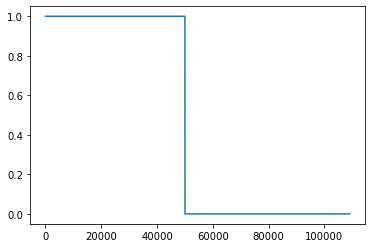

In [64]:
#### Warning: adding noise from Thai experiment (n_Thai samples)
# Training data: X_s_tr: All positive labels in database EXCEPT Culex/00.
#                X_n_tr: All negative labels in database EXCEPT Culex/00 (no Culex/00 labels anyway)
#                X_n_Thai: All labels ASSUMED to be negative (non 1s logic)
#                X_n_add_CDC: confirmed 0s from background.wav in CDC set/
# select a balanced subset of noise which matches the duration of the training positive set

# N_noise = len(X_tr)

# n_tr = X_s_tr_l - X_n_tr_l - N_n_Thai
# X_tr = np.vstack([shuffle(X_s_tr), shuffle(X_n_Thai)[:N_noise]])

X_tr = np.vstack([shuffle(X_s_tr)[:50000], X_n_tr, X_n_add_CDC])
y_tr = np.zeros(len(X_tr))
y_tr[:len(X_s_tr[:50000])] = 1
plt.plot(y_tr)
# y_te = np.hstack([np.ones(len(X_s_te)), np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex))])
y_te = np.ones(len(X_s_te))


clf = RandomForestClassifier(max_depth=2, random_state=0, verbose=0, n_jobs=-1)
clf.fit(X_tr,y_tr)


Signal acc 0.830498033454959
Noise acc 0.9948866937826845


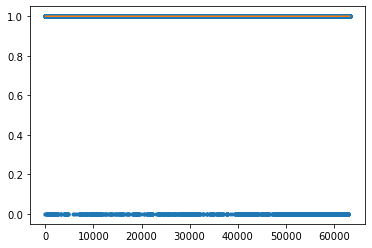

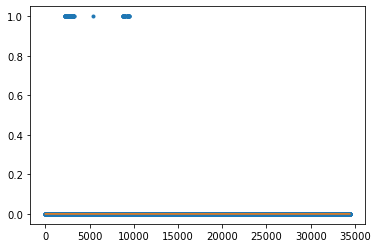

In [65]:
preds = clf.predict(np.vstack([X_s_te]))
print('Signal acc', accuracy_score(y_te, preds))

plt.figure()
plt.plot(preds, '.')
plt.plot(y_te)

preds = clf.predict(np.vstack([X_n_Culex, X_n_add_Culex]))
y_te = np.hstack([np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex))])

print('Noise acc', accuracy_score(y_te, preds))
plt.figure()
plt.plot(preds, '.')
plt.plot(y_te)


### Create y labels

## Train Model

# Evaluate Model

In [66]:
print('Test set processing...')
species_wav_dict = {}
for species in df_test["species"].unique():
    x, signal_length = get_wav_for_df(df_test[df_test["species"] == species], 8000)
    species_wav_dict[species.strip().strip("\'")] = [x, signal_length] # Correct for odd spacing and syntax in database (Maybe check SQL query?
    print('Completed wav extraction for species', species)

Test set processing...
Completed wav extraction for species  'an dirus'
Completed wav extraction for species  'an harrisoni'
Completed wav extraction for species  'an minimus'
Completed wav extraction for species  'an maculatus'
Completed wav extraction for species  'an barbirostris'
Completed wav extraction for species  None


In [67]:
for species in df_train["species"].unique():
    print('Species', species)

Species  'ae albopictus'
Species  'an albimanus'
Species  'an arabiensis'
Species  'an atroparvus'
Species  'an coluzzii'
Species  'an dirus'
Species  'an farauti'
Species  'an freeborni'
Species  'an funestus'
Species  'an merus'
Species  'an minimus'
Species  'an quadriannulatus'
Species  'culex quinquefasciatus'
Species  'an sinensis'
Species  'an stephensi'
Species  'culex tarsalis'
Species  'toxorhynchites brevipalpis'
Species  'an gambiae'
Species  'ae aegypti'


In [68]:
print('Test set processing...')
for species in species_wav_dict.keys():
    X_test, n_samples_test = get_feat(species_wav_dict[species][0], sr=8000)
    X_test = reshape_feat(X_test, n_samples_test)
    y_test = np.ones(np.shape(X_test)[0])
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds) 
    print('Seconds for species:', species,  species_wav_dict[species][1], 'acc', acc)

Test set processing...
Seconds for species: an dirus 909.795899 acc 0.9666456450143648
Seconds for species: an harrisoni 980.3857019999994 acc 0.9711275848614904
Seconds for species: an minimus 61.524393999999994 acc 0.9824016563146998
Seconds for species: an maculatus 830.4170410000003 acc 0.9638720564547059
Seconds for species: an barbirostris 87.81996999999996 acc 0.8175872093023255
Seconds for species: None 1166.0678930000001 acc 0.5037470597888518


In [69]:
preds = clf.predict(X_n_Culex)
acc = accuracy_score(np.zeros(len(X_n_Culex)),preds) 
print('Seconds for Culex noise:', N_n_Culex, 'acc', acc)

preds = clf.predict(X_n_add_Culex)
acc = accuracy_score(np.zeros(len(X_n_add_Culex)),preds) 
print('Seconds for Culex additional noise files:', N_n_add_Culex, 'acc', acc)

Seconds for Culex noise: 9701 acc 0.9818575404597464
Seconds for Culex additional noise files: 24719 acc 1.0


# Bug reports

* ```19 June 2018_359_379cow```: End time of signal is longer than actual signal?

* Events are marked with mosquito "deaths" as point labels, where end time = start time:

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 933```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 935```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 936```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 938```

* Larvae are not marked as mosquito, species information absent from labels

* Noise labels are not consistent in experiments: some data is marked as "background", some is untagged, some recordings contain positive labels with the implication that the negative labels are noise, whereas other recordings only strongly label positive events, ignoring lower SNR positives

645-657: label missing species for:

`98.014746	105.544811	#651cow
109.454388	131.549004	#652cow
136.725064	156.988787	#653cow
161.201218	177.720557	#654cow
182.111948	194.818073	#655cow
197.571296	206.064990	#656cow
209.602882	223.313930	#657cow`

species present in:

`26.413735	37.526432	#645COW
42.499442	55.591018	#646COW
60.715454	68.906293	#647COW`




#235-239.txt and 17 June 2018_235-239cow.txt: recordings appear really similar other than sample rate:
# two label tracks are supplied (???)
235-239 MISSING LAST LABEL: 20 SEC MOSQUITO LABELLED AS NOISE
    
WE CANNOT ASSUME NON 1S ARE NOISE: in Thai data, we filtered all the data by *species info having to be in original database entry*, hence this discarded a significant amount of training data and led to the non 1 assumption not being true in Thai, but working fine in Culex.
    

# Fixes

Load dataframe with mosquito +ve but no species present in same query. Can filter further in pandas in Python to test by species